In [2]:

# required imports

import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Softmax, Dense,Dropout,BatchNormalization,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam, SGD
from dataclasses import dataclass
import shutil

In [3]:
# define data pipeline paths 

# todo: uncomment for kaggle environment
base_dataset_path = r"/kaggle/input/num-ds-org"
base_aug_dataset_path = r"/kaggle/working/num-ds-aug"

# todo: uncomment for local environment
# base_dataset_path = r"..\dataset\dataset"
# base_aug_dataset_path = r"..\dataset\dataset_aug"

train_dir = os.path.join(base_dataset_path, 'Training_data')
valid_dir = os.path.join(base_dataset_path, 'Validation_data')
test_dir = os.path.join(base_dataset_path, 'Test_data')
train_dir_aug = os.path.join(base_aug_dataset_path, 'Training_data')
valid_dir_aug = os.path.join(base_aug_dataset_path, 'Validation_data')
test_dir_aug = os.path.join(base_aug_dataset_path, 'Test_data')

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))



In [4]:
# define label map dictionary

labelDict = {
    "num0":"0",
    "num1":"1",
    "num2":"2",
    "num3":"3",
    "num4":"4",
    "num5":"5",
    "num6":"6",
    "num7":"7",
    "num8":"8",
    "num9":"9"
}

In [5]:
# define function to add gsussian blur

def add_gaussian_noise_to_img(image, noise_factor=0.1):
    """
    Add Gaussian noise to an input image based on the noise factor

    Input Parameters:
    - image: Input image (numpy array).
    - noise_factor: Standard deviation of the Gaussian noise relative to pixel values.

    Returns:
    - Noisy image (numpy array).
    """


    # normalize pixel values between 0 and 1
    image_float = image.astype(np.float32) / 255.0
    
    # noise varies according to the nise factor
    noise = np.random.normal(0, noise_factor, image_float.shape)

    noisy_image = image_float + noise
    noisy_image = np.clip(noisy_image, 0, 1 )

    # restore image data type
    return (noisy_image * 255).astype(np.uint8)

In [6]:
# define function to add augmentations to image dataset 

def augment_image(image, noise_factor=0.1, augment_factor=10):
    """
    # image augmentations using OpenCV

    Input Parameters:
    - image: Input image (numpy array).
    - noise_factor: standard deviation of the Gaussian noise relative to pixel values.
    - augment_factor: factor relative to image augmentation like resize, rotate, flip, translate/shift

    Returns:
    - augmented image (numpy array).
    
    """
        
    # flip the image based on threshold related to augment factor 
    if np.random.rand() > (augment_factor/11):
        image = cv2.flip(image, 1)  # Horizontal flip

    # Rotate the image based on angle related to augment factor 
    angle = np.random.uniform((-2*augment_factor), (2*augment_factor))
    (h, w) = image.shape[:2]
    center = (w // 2, h // 2)
    mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    image = cv2.warpAffine(image, mat, (w, h))

    # Resize the image based on augment factor
    # image = cv2.resize(image, (28, 28))  # Example for MNIST size
    image = cv2.resize(image, ((augment_factor*5), (augment_factor*5)))  # Example for MNIST size

    # add gaussian noise
    image = add_gaussian_noise_to_img(image, noise_factor)   

    return image


In [7]:
# process training images augmentation

train_sub_dirs = os.listdir(train_dir)

for subDir in train_sub_dirs:
    subDirPath = os.path.join(train_dir, subDir)
    files = os.listdir(subDirPath)

    for file in files:
        if not (file.endswith('.png')):
            continue

        # load image file (use a valid image path)
        filePath = os.path.join(subDirPath, file)

        # todo:cleanup 
        # image = cv2.imread(filePath, cv2.IMREAD_GRAYSCALE)
        image = cv2.imread(filePath, -1)

        # add Gaussian noise to the image
        noise_factor = 0.1  # adjust this factor for more or less noise
        augment_factor = 10
        image_aug = augment_image(image, noise_factor, augment_factor)

        # save to augment subfolder
        # process label transformation (eg. num1 to 1)
        subDirAug = labelDict[subDir]
        subDirPathAug = os.path.join(train_dir_aug, subDirAug)
        if not (os.path.exists(subDirPathAug)):
            os.makedirs(subDirPathAug)

        filePathAug = os.path.join(subDirPathAug, file)       
        cv2.imwrite(filePathAug, image_aug)


In [9]:

# Prepare validation images data 

# move to aug folder and correct class names
source = os.path.join(base_dataset_path, 'Validation_data')
destination = os.path.join(base_aug_dataset_path, 'Validation_data')

# delete folder if already exist
# Define the folder path
folder_path = destination

# Check if the folder exists and delete it if it does
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    try:
        shutil.rmtree(folder_path)  # This will delete the folder and its contents
        print(f"Empty folder '{folder_path}' has been deleted.")
    except Exception as e:
        print(f"Error: {e}")
else:
    print(f"Folder '{folder_path}' does not exist.")

# Move the folder
try:
    shutil.copytree(source, destination)
    print(f"Folder moved from {source} to {destination}")
except Exception as e:
    print(f"Warning: {e}")
    
valid_sub_dirs_aug = os.listdir(valid_dir_aug)

for subDir_aug in valid_sub_dirs_aug:
    subDirPath_aug = os.path.join(valid_dir_aug, subDir_aug)
    
    subDir_aug_ch = labelDict[subDir_aug]
    
    subDirPath_aug_ch = os.path.join(valid_dir_aug, subDir_aug_ch)
   
    # Define the current folder name and the new folder name
    current_name = subDirPath_aug
    new_name = subDirPath_aug_ch

    # Rename the folder
    try:
        os.rename(current_name, new_name)
        print(f"Folder renamed from {current_name} to {new_name}")
    except FileNotFoundError:
        print("The specified folder does not exist.")
    except FileExistsError:
            print("A folder with the new name already exists.")
    except Exception as e:
        print(f"Error: {e}")

Empty folder '/kaggle/working/num-ds-aug/Validation_data' has been deleted.
Folder moved from /kaggle/input/num-ds-org/Validation_data to /kaggle/working/num-ds-aug/Validation_data
Folder renamed from /kaggle/working/num-ds-aug/Validation_data/num4 to /kaggle/working/num-ds-aug/Validation_data/4
Folder renamed from /kaggle/working/num-ds-aug/Validation_data/num5 to /kaggle/working/num-ds-aug/Validation_data/5
Folder renamed from /kaggle/working/num-ds-aug/Validation_data/num9 to /kaggle/working/num-ds-aug/Validation_data/9
Folder renamed from /kaggle/working/num-ds-aug/Validation_data/num3 to /kaggle/working/num-ds-aug/Validation_data/3
Folder renamed from /kaggle/working/num-ds-aug/Validation_data/num1 to /kaggle/working/num-ds-aug/Validation_data/1
Folder renamed from /kaggle/working/num-ds-aug/Validation_data/num2 to /kaggle/working/num-ds-aug/Validation_data/2
Folder renamed from /kaggle/working/num-ds-aug/Validation_data/num7 to /kaggle/working/num-ds-aug/Validation_data/7
Folder 

In [10]:
# Process Test images data 

# move to aug folder to aug folder
source = os.path.join(base_dataset_path, 'Test_data')
destination = os.path.join(base_aug_dataset_path, 'Test_data')

# delete folder if already exist
# Define the folder path
folder_path = destination

# Check if the folder exists and delete it if it does
if os.path.exists(folder_path) and os.path.isdir(folder_path):
    try:
        shutil.rmtree(folder_path)  # This will delete the folder and its contents
        print(f"Empty folder '{folder_path}' has been deleted.")
    except Exception as e:
        print(f"Error: {e}")
else:
    print(f"Folder '{folder_path}' does not exist.")

# Move the folder
try:
    shutil.copytree(source, destination)
    print(f"Folder moved from {source} to {destination}")
except Exception as e:
    print(f"Warning: {e}")

Empty folder '/kaggle/working/num-ds-aug/Test_data' has been deleted.
Folder moved from /kaggle/input/num-ds-org/Test_data to /kaggle/working/num-ds-aug/Test_data


In [9]:
# Define Data Generator

gen = ImageDataGenerator()

In [10]:
# Define seed

SEED = 21

In [11]:
# Training config

@dataclass(frozen=True)
class TrainingConfig:
    BATCH_SIZE:     int   = 10
    EPOCHS:         int   = 100
    LEARNING_RATE:  float = 0.0001
    

In [12]:
# Acquire Training images from the directory using flow_from_directory() method.
train_datagen = gen.flow_from_directory(directory = '/kaggle/working/num-ds-aug/Training_data',
                                        target_size = (224, 224),
                                        color_mode = "rgb",
                                        classes = None,
                                        class_mode = "categorical",
                                        batch_size = TrainingConfig.BATCH_SIZE,
                                        shuffle = True,
                                        seed = SEED,
                                        interpolation = "nearest")

Found 275 images belonging to 10 classes.


In [13]:
# Acquire Validation images from the directory using flow_from_directory() method.
val_datagen = gen.flow_from_directory(directory = '/kaggle/working/num-ds-aug/Validation_data',
                                        target_size = (224, 224),
                                        color_mode = "rgb",
                                        classes = None,
                                        class_mode = "categorical",
                                        batch_size = TrainingConfig.BATCH_SIZE,
                                        shuffle = False,
                                        seed = SEED,
                                        interpolation = "nearest")

Found 100 images belonging to 10 classes.


In [14]:
# Acquire Test images from the directory using flow_from_directory() method.
test_datagen = gen.flow_from_directory(directory = '/kaggle/working/num-ds-aug/Test_data',
                                        target_size = (224, 224),
                                        color_mode = "rgb",
                                        classes = None,
                                        class_mode = "categorical",
                                        batch_size = TrainingConfig.BATCH_SIZE,
                                        shuffle = False,
                                        seed = SEED,
                                        interpolation = "nearest")

Found 165 images belonging to 10 classes.


In [15]:
# Classes of images in test dataset
classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

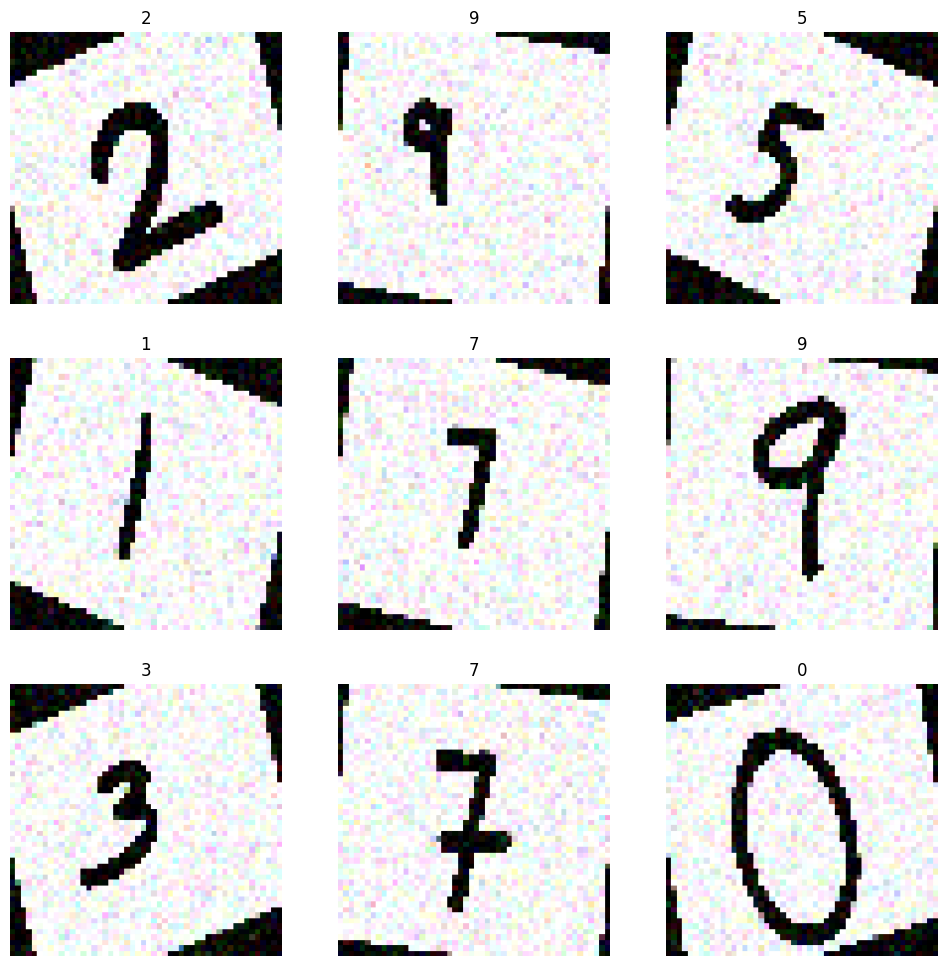

In [16]:
# Preparing the Samples and Plot for displaying output

# Create figure
fig = plt.figure(figsize = (12, 12))
for i in range(9):
  plt.subplot(330 + 1 + i)
  img, label = next(train_datagen)

  label = label[0].astype('uint8')
  label = np.squeeze(label)
  label = np.argmax(label, axis = 0)

  plt.axis('off')
  plt.imshow(img[0].astype(np.uint8))
  # plt.imshow(img[0][:,:,::-1].astype(np.uint8))
  plt.title(classes[label])

# Displaying the figure
plt.show()

In [17]:
# Load the VGG16 model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze all layers
for layer in base_model.layers:
    layer.trainable = False

# Train the last four layers
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Create a new model on top
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')  # Change 10 to the number of classes
])

# Compile the model

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=TrainingConfig.LEARNING_RATE),
                    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                    metrics=['accuracy'],
                   ) 

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [23]:
# Training the model
history = model.fit(train_datagen,
                    epochs = TrainingConfig.EPOCHS,
                    # steps_per_epoch = (len(train_datagen)),
                    batch_size = TrainingConfig.BATCH_SIZE,
                    validation_data = val_datagen,
                    # validation_steps = (len(val_datagen)),
                    shuffle = True,
                    # callbacks = callback
                   )

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1729277296.629197     152 service.cc:145] XLA service 0x57d67311cfe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729277296.629264     152 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729277296.629269     152 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 3/28 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - accuracy: 0.1278 - loss: 18.7462

I0000 00:00:1729277307.136337     152 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28/28 ━━━━━━━━━━━━━━━━━━━━ 22s 349ms/step - accuracy: 0.1163 - loss: 10.1748 - val_accuracy: 0.1200 - val_loss: 3.6386
Epoch 2/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.1907 - loss: 2.2458 - val_accuracy: 0.1400 - val_loss: 3.5820
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.2393 - loss: 2.0851 - val_accuracy: 0.1200 - val_loss: 3.7282
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.3356 - loss: 1.8998 - val_accuracy: 0.1300 - val_loss: 3.5399
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.3560 - loss: 1.8912 - val_accuracy: 0.1300 - val_loss: 3.7650
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.4595 - loss: 1.5406 - val_accuracy: 0.2600 - val_loss: 3.7002
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 123ms/step - accuracy: 0.5279 - loss: 1.3348 - val_accuracy: 0.2100 - val_loss: 3.1501
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 3s 124ms/step - accuracy: 0.4717 - loss: 1.3202 - val_accuracy: 0.27

In [26]:
# save model

model.save('vgg16_num_classifier.h5')

In [18]:
# load model

loaded_model = tf.keras.models.load_model('vgg16_num_classifier.h5')

loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     6,422,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 21,140,044 (80.64 MB)

 Trainable params: 13,504,778 (51.52 MB)

 Non-trainable params: 7,635,264 (29.13 MB)

 Optimizer params: 2 (12.00 B)

In [19]:
# Evaluate the model

loss, accuracy = loaded_model.evaluate(test_datagen)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


17/17 ━━━━━━━━━━━━━━━━━━━━ 41s 2s/step - accuracy: 0.1209 - loss: 3.2659
Test Loss: 3.203836441040039
Test Accuracy: 0.13333334028720856


In [22]:
# Make Predictions

# Predict the classes
predictions = loaded_model.predict(test_datagen)

print('predictions[0] = ', predictions[0])

# Convert predictions to class labels
predicted_classes = np.argmax(predictions, axis=1)

print('predicted_classes[0] = ', predicted_classes[0] )

# Get true labels
true_classes = test_datagen.classes

print('true_classes = ', true_classes)

17/17 ━━━━━━━━━━━━━━━━━━━━ 40s 2s/step
predictions[0] =  [9.5740366e-01 1.3150937e-03 1.5818747e-04 1.8118185e-04 1.8490050e-02
 7.5433641e-03 5.3227175e-04 4.2413319e-03 7.4875564e-03 2.6472528e-03]
predicted_classes[0] =  0
true_classes =  [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 6 6 6 6 6 6 6 6 6 6 6 6
 6 6 6 6 6 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9 9]


Precision: 0.22795798898071623
Recall: 0.13333333333333333
F1 Score: 0.13448071547540108


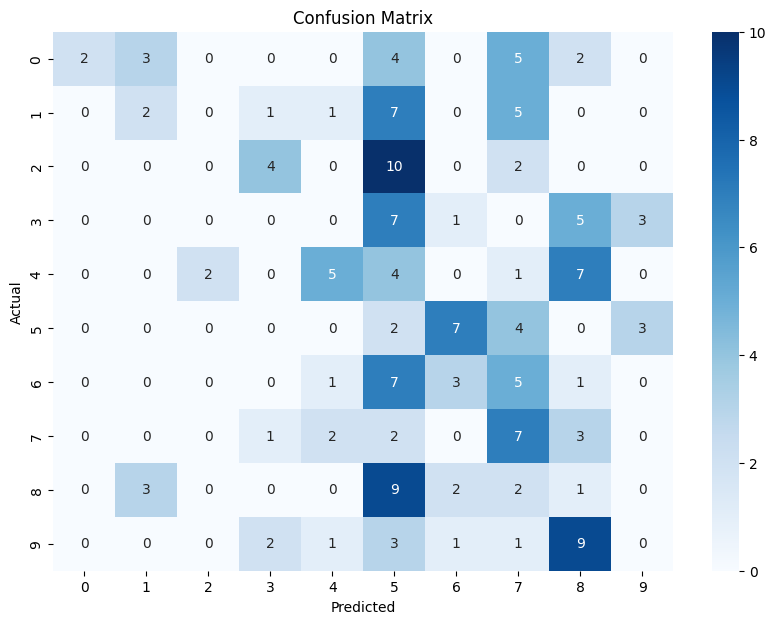

In [21]:
# Compute precision, recall, and F1 score

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns

precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=list(test_datagen.class_indices.keys()),
            yticklabels=list(test_datagen.class_indices.keys()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
